# COBRApyで論文再現(1)

腸内細菌773種のGEM(Genome-scale metabolic model)のリファレンスセットAGORAを構築・解析した2017年の論文をCOBRApyで再現してみる.

Citation: Magnúsdóttir, S., Heinken, A., Kutt, L. et al. Generation of genome-scale metabolic reconstructions for 773 members of the human gut microbiota. Nat Biotechnol 35, 81–89 (2017). https://doi.org/10.1038/nbt.3703

In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import cobra
import re
import tqdm
from plotnine import *

## データをダウンロードする

* AGORA GEMs: https://github.com/VirtualMetabolicHuman/AGORA
* Species metadata: [Supplementary Table 5](https://static-content.springer.com/esm/art%3A10.1038%2Fnbt.3703/MediaObjects/41587_2017_BFnbt3703_MOESM6_ESM.xlsx)
* Reaction/Metabolite metadata: [Supplementary Table 14](https://static-content.springer.com/esm/art%3A10.1038%2Fnbt.3703/MediaObjects/41587_2017_BFnbt3703_MOESM10_ESM.xlsx)

### AGORA

In [4]:
!git clone https://github.com/VirtualMetabolicHuman/AGORA

Cloning into 'AGORA'...
remote: Enumerating objects: 9115, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 9115 (delta 32), reused 59 (delta 26), pack-reused 9042
Receiving objects: 100% (9115/9115), 695.33 MiB | 7.64 MiB/s, done.
Resolving deltas: 100% (4939/4939), done.
Updating files: 100% (6549/6549), done.


In [7]:
!tree AGORA -L 3 -d

AGORA
├── CurrentVersion
│   └── AGORA_1_03
│       ├── AGORA_1_03_With_Mucins_mat
│       ├── AGORA_1_03_With_Mucins_sbml
│       ├── AGORA_1_03_mat
│       └── AGORA_1_03_sbml
└── Previous_Versions
    └── AGORA1.02
        ├── AGORA_102_Model_AvEuropeanDiet_SMBL
        ├── AGORA_102_Model_AvEuropeanDiet_mat
        ├── Agora_102_Reconstruction_mat
        └── Agora_102_Reconstruction_sbml

12 directories


In [3]:
import glob
files = np.sort(glob.glob("AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_mat/*mat"))
sbml_files = np.sort(glob.glob("AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_sbml/*xml"))
bacteria_names = [f.split("/")[-1].replace(".xml", "") for f in sbml_files]
files[:5], sbml_files[:5], bacteria_names[:5]

(array(['AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_mat/Abiotrophia_defectiva_ATCC_49176.mat',
        'AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_mat/Achromobacter_xylosoxidans_A8.mat',
        'AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_mat/Achromobacter_xylosoxidans_NBRC_15126.mat',
        'AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_mat/Acidaminococcus_fermentans_DSM_20731.mat',
        'AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_mat/Acidaminococcus_intestini_RyC_MR95.mat'],
       dtype='<U116'),
 array(['AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_sbml/Abiotrophia_defectiva_ATCC_49176.xml',
        'AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_sbml/Achromobacter_xylosoxidans_A8.xml',
        'AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_sbml/Achromobacter_xylosoxidans_NBRC_15126.xml',
        'AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_sbml/Acidaminococcus_fermentans_DSM_20731.xml',
        'AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_sbml/Acidaminococcus_intestini_RyC_MR95.xml'],
    

### Species metadata

In [30]:
!mkdir Magnusdottir-2017-Nat_Biotechnol
!curl "https://static-content.springer.com/esm/art%3A10.1038%2Fnbt.3703/MediaObjects/41587_2017_BFnbt3703_MOESM6_ESM.xlsx" --output Magnusdottir-2017-Nat_Biotechnol/41587_2017_BFnbt3703_MOESM6_ESM.xlsx

mkdir: Magnusdottir-2017-Nat_Biotechnol: File exists
--2021-12-28 23:39:38--  https://static-content.springer.com/esm/art%3A10.1038%2Fnbt.3703/MediaObjects/41587_2017_BFnbt3703_MOESM6_ESM.xlsx
Resolving static-content.springer.com... 151.101.112.95
Connecting to static-content.springer.com|151.101.112.95|:443... connected.
OpenSSL: error:1407742E:SSL routines:SSL23_GET_SERVER_HELLO:tlsv1 alert protocol version
Unable to establish SSL connection.


In [38]:
meta = pd.read_excel("Magnusdottir-2017-Nat_Biotechnol/41587_2017_BFnbt3703_MOESM6_ESM.xlsx",
                     skiprows=2)
meta

,Organism,ModelAGORA,Kingdom,Phylum,Class,Order,Family,Genus,Species,Platform,...,Draft_created,Platform.1,Kbase_genome_ID,PubSEED_ID,NCBI_ID,IMG_ID,Genome_size,Genes,Reactions,Unique metabolites
0,Abiotrophia defectiva ATCC 49176,Abiotrophia_defectiva_ATCC_49176,Bacteria,Firmicutes,Bacilli,Lactobacillales,Aerococcaceae,Abiotrophia,Abiotrophia defectiva,ModelSEED,...,2014-07-01,ModelSEED,NaN,Abiotrophia defectiva ATCC 49176 (592010.4),592010.0,2.562617e+09,2041839,598,1069,840
1,Acidaminococcus fermentans DSM 20731,Acidaminococcus_fermentans_DSM_20731,Bacteria,Firmicutes,Negativicutes,Acidaminococcales,Acidiaminococcaceae,Acidaminococcus,Acidaminococcus fermentans,KBase,...,2016-04-17,Kbase,kb|g.2555,Acidaminococcus fermentans DSM 20731 (591001.3),591001.0,6.463119e+08,2329769,646,1090,903
2,Acidaminococcus intestini RyC-MR95,Acidaminococcus_intestini_RyC_MR95,Bacteria,Firmicutes,Negativicutes,Selenomonadales,Acidaminococcaceae,Acidaminococcus,Acidaminococcus intestini,ModelSEED,...,2014-08-03,ModelSEED,NaN,Acidaminococcus intestini RyC-MR95 (568816.4),568816.0,2.511231e+09,2487765,599,994,827
3,Acidaminococcus sp. D21,Acidaminococcus_sp_D21,Bacteria,Firmicutes,Negativicutes,Selenomonadales,Acidaminococcaceae,Acidaminococcus,unclassified Acidaminococcus,ModelSEED,...,2012-06-29,ModelSEED,NaN,Acidaminococcus sp. D21 (563191.3),563191.0,6.438861e+08,2238973,598,851,768
4,Acinetobacter calcoaceticus PHEA-2,Acinetobacter_calcoaceticus_PHEA_2,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Acinetobacter,Acinetobacter calcoaceticus,KBase,...,2016-04-18,Kbase,kb|g.3519,Acinetobacter calcoaceticus PHEA-2 (871585.3),871585.0,6.503779e+08,3862530,1026,1561,1165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,Yersinia frederiksenii ATCC 33641,Yersinia_frederiksenii_ATCC_33641,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Yersina,Yersinia frederiksenii,KBase,...,2016-04-18,Kbase,kb|g.1009,Yersinia frederiksenii ATCC 33641 (349966.3),349966.0,6.383412e+08,4845578,1287,1729,1214
769,Yersinia kristensenii ATCC 33638,Yersinia_kristensenii_ATCC_33638,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Yersina,Yersinia kristensenii,KBase,...,2016-05-29,Kbase,kb|g.2094,Yersinia kristensenii ATCC 33638 (527012.3),527012.0,6.450588e+08,5042394,1391,1695,1189
770,Yersinia pseudotuberculosis YPIII,Yersinia_pseudotuberculosis_YPIII,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Yersina,Yersinia pseudotuberculosis,KBase,...,2016-04-18,Kbase,kb|g.1842,Yersinia pseudotuberculosis YPIII (502800.3),502800.0,6.415227e+08,4689441,1113,1646,1186
771,Yersinia rohdei ATCC 43380,Yersinia_rohdei_ATCC_43380,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Yersina,Yersinia rohdei,KBase,...,2016-04-18,Kbase,kb|g.2092,Yersinia rohdei ATCC 43380 (527004.3),527004.0,6.450588e+08,4317478,1197,1689,1188


In [44]:
# four bacteria in Table S5 were not found
meta.assign(key=lambda x: x.ModelAGORA.isin(bacteria_names)).query("not key")

,Organism,ModelAGORA,Kingdom,Phylum,Class,Order,Family,Genus,Species,Platform,...,Platform.1,Kbase_genome_ID,PubSEED_ID,NCBI_ID,IMG_ID,Genome_size,Genes,Reactions,Unique metabolites,key
74,Bacillus timonensis JC401,Bacillus_timonensis_JC401,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus timonensis,KBase,...,Kbase,kb|g.23344,NaN,1095770.0,NaN,4608729,1068,1503,1134,False
169,Bifidobacterium stercoris ATCC 43183,Bifidobacterium_stercoris_ATCC_43183,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,Bifidobacterium stercoris,KBase,...,Kbase,kb|g.239977,NaN,46506.0,2.597490e+09,2304613,525,1045,860,False
411,Gemella moribillum M424,Gemella_moribillum_M424,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillales Incertae Sedis XI,Gemella,Gemella moribillum,KBase,...,Kbase,kb|g.2334,Gemella moribillum M424 (562982.3),562982.0,NaN,1752918,484,929,744,False
631,Proteus mirabilis ATCC 35198,Proteus_mirabilis_ATCC_35198,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Proteus,Proteus mirabilis,KBase,...,Kbase,kb|g.1703,NaN,471881.0,NaN,3749229,1264,1478,1096,False


In [59]:
meta = meta.loc[meta.ModelAGORA.isin(bacteria_names), :]
meta.shape

(769, 25)

### Reaction/Metabolite metadata

In [56]:
!curl https://static-content.springer.com/esm/art%3A10.1038%2Fnbt.3703/MediaObjects/41587_2017_BFnbt3703_MOESM10_ESM.xlsx --output Magnusdottir-2017-Nat_Biotechnol/41587_2017_BFnbt3703_MOESM10_ESM.xlsx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  310k  100  310k    0     0   627k      0 --:--:-- --:--:-- --:--:--  626k


In [58]:
r_meta = pd.read_excel("Magnusdottir-2017-Nat_Biotechnol/41587_2017_BFnbt3703_MOESM10_ESM.xlsx", skiprows=3)
r_meta

,Reaction abbreviation,Reaction name,Reaction formula,EC Number,Subsystem,KEGG Orthology,KEGG Reaction,COG
0,12DGR180ti,"1,2 diacylglycerol transport (extracellular to...",12dgr180[e] -> 12dgr180[c],NaN,"Transport, extracellular",NaN,NaN,NaN
1,12PPDSDH,S Propane 1 2 diol dehydratase,12ppd_S[c] -> h2o[c] + ppal[c],4.2.1.28,Propanoate metabolism,K01699 K13919 K13920,R02376,COG4909
2,12PPDt,"S-Propane-1,2-diol facilitated transport",12ppd_S[e] <=> 12ppd_S[c],NaN,"Transport, extracellular",NaN,NaN,NaN
3,13DAMPPOX,"1,3-Diaminopropane:oxygen oxidoreductase (deam...",13dampp[c] + h2o[c] + o2[c] <=> bamppald[c] +...,NaN,beta-Alanine metabolism,NaN,NaN,NaN
4,13PPDHr,"1,3-propanediol dehydrogenase, reversible",3hppnl[c] + h[c] + nadh[c] <=> 13ppd[c] + nad[c],1.1.1.202,Glycerophospholipid metabolism,K00086,R03119,COG1454
...,...,...,...,...,...,...,...,...
3187,XYLTH,D-Xylonate hydro-lyase,xylt_D[c] -> h2o[c] + 2d3dxylt[c],4.2.1.82,Pentose and glucuronate interconversions,K14275,R02429,NaN
3188,XYLUGLC_DEGe,"Xyluglucan degradation, gut microbiota specific",xyluglc[e] + 1133 h2o[e] -> 600 glc_D[e] + 360...,NaN,Plant polysaccharide degradation,NaN,NaN,NaN
3189,YUMPS,yUMP synthetase,r5p[c] + ura[c] <=> h2o[c] + psd5p[c],4.2.1.70,Pyrimidine synthesis,K01718 K16329 K16330,R01055,COG2313 COG0524
3190,ZN2t4,ZN2t4,h[e] + k[e] + zn2[c] <=> h[c] + k[c] + zn2[e],NaN,"Transport, extracellular",NaN,NaN,NaN


In [127]:
m_meta = pd.read_excel("Magnusdottir-2017-Nat_Biotechnol/41587_2017_BFnbt3703_MOESM10_ESM.xlsx", skiprows=3, sheet_name=1)
m_meta

,Metabolite abbreviation,Metabolite name,Charged formula,Charge
0,10fthf,10-Formyltetrahydrofolate,C20H21N7O7,-2
1,10fthf5glu,10-formyltetrahydrofolate-[Glu](5),C40H45N11O19,-6
2,10m3hddcaACP,10-methyl-3-hydroxy-dodecanoyl-ACP,C24H45N2O9PRS,-1
3,10m3hundecACP,10-methyl-3-hydroxy-undecanoyl-ACP,C23H43N2O9PRS,-1
4,10m3oddcaACP,10-methyl-3-oxo-dodecanoyl-ACP,C24H43N2O9PRS,-1
...,...,...,...,...
1684,xylt_D,D-Xylonate,C5H9O6,-1
1685,xylu_D,D-xylulose,C5H10O5,0
1686,xylu_L,L-xylulose,C5H10O5,0
1687,xyluglc,"Xyluglucan, PMID:16663672, Fry SC 1989. 600 gl...",C6438H10610O5245,0


## Figure 1

各生物種のGEMsから代謝反応と代謝物のリストをパースする

In [ ]:
s2r = []
s2m = []
for s in tqdm.tqdm(meta.ModelAGORA):
    file = "AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_sbml/{s}.xml".format(s=s)
    model = cobra.io.read_sbml_model(file)
    s2r.append(pd.DataFrame({"species": s, "reactions":[x.id for x in model.reactions]}))
    s2m.append(pd.DataFrame({"species": s, "metabolites":[x.id for x in model.metabolites]}))


100%|██████████| 769/769 [16:55<00:00,  1.32s/it]


In [ ]:
s2r = pd.concat(s2r, ignore_index=True)
s2r.to_csv("Magnusdottir-2017-Nat_Biotechnol/species2reaction.tsv", sep="\t", index=False)

s2m = pd.concat(s2m, ignore_index=True)
s2m.to_csv("Magnusdottir-2017-Nat_Biotechnol/species2metabolite.tsv", sep="\t", index=False)

/Users/maruyamatooru/opt/anaconda3/envs/cobra/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 1 rows containing non-finite values.


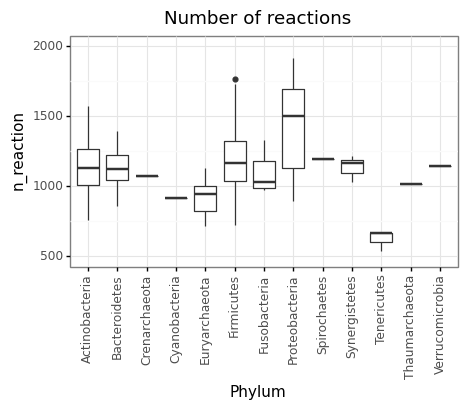

<ggplot: (8771266013745)>

In [215]:
figmat = s2r.groupby("species").size().rename("n_reaction").reset_index()
figmat = pd.merge(figmat, meta.rename(columns={"ModelAGORA":"species"}).loc[:, ["species", "Phylum"]], how="left", on="species")

fig = (
    ggplot(figmat) +
        geom_boxplot(aes(x="Phylum", y="n_reaction")) +
        theme_bw() +
        theme(axis_text_x=element_text(angle=90), figure_size=(5,3)) +
        scale_y_continuous(limits=[500, 2000], breaks=[500, 1000, 1500, 2000]) +
        ggtitle("Number of reactions")
)
fig

/Users/maruyamatooru/opt/anaconda3/envs/cobra/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 1 rows containing non-finite values.


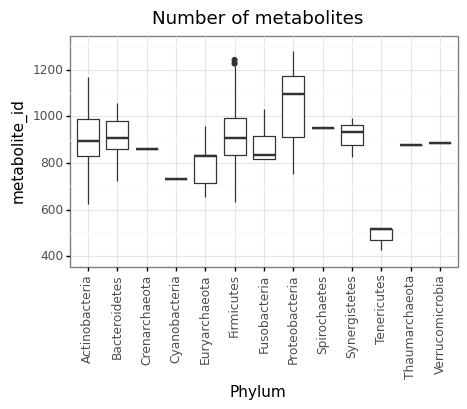

<ggplot: (8771300322467)>

In [223]:
figmat = s2m.assign(metabolite_id = lambda x: [y[:-3] for y in x.metabolites],
                    location = lambda x: [y[-2] for y in x.metabolites]).\ # merge extra/intracellular metabolites
            groupby(["species"]).metabolite_id.nunique()
figmat = pd.merge(figmat, meta.rename(columns={"ModelAGORA":"species"}).loc[:, ["species", "Phylum"]], how="left", on="species")

fig = (
    ggplot(figmat) +
        geom_boxplot(aes(x="Phylum", y="metabolite_id")) +
        theme_bw() +
        theme(axis_text_x=element_text(angle=90), figure_size=(5,3)) +
        scale_y_continuous(limits=[400, 1300], breaks=[400,600,800,1000,1200]) +
        ggtitle("Number of metabolites")
)
fig

#### Growth rate

Fig.1では2種類の食事(Western diet, High fiber diet)を摂取した場合と、2酸素条件 (Aerobic, Anaerobic)における各細菌の生育率を計算している。食事の定義は論文のSupplementary Table 15に記載されている。数値の単位はmmol/gDW/h。hは時間。gDWはgram dry weight (菌体の乾燥時の重量)。単位時間・単位菌体量あたりの物質量を表す。

以下のExchange reaction IDが古いIDだったようなのでマニュアルで変更した。

* EX_glc(e) -> EX_glc_D(e)

In [290]:
diet = pd.read_table("Magnusdottir-2017-Nat_Biotechnol/Diet.tsv")
diet

,Metabolite ID,Exchange reaction ID,Metabolite name,Western Diet,High fiber Diet
0,arab_L,EX_arab_L(e),L-arabinose,0.178783,0.047368
1,cellb,EX_cellb(e),Cellobiose,0.074493,0.019737
2,drib,EX_drib(e),2-deoxy-D-ribose,0.178783,0.047368
3,fru,EX_fru(e),D-Fructose,0.148986,0.039474
4,fuc_L,EX_fuc_L(e),L-fucose,0.148986,0.039474
...,...,...,...,...,...
159,thymd,EX_thymd(e),Thymidine,1.000000,1.000000
160,ura,EX_ura(e),Uracil,1.000000,1.000000
161,uri,EX_uri(e),Uridine,1.000000,1.000000
162,xan,EX_xan(e),Xanthine,1.000000,1.000000


以下のExchange reactionはバクテリアには存在していないことを[Virtual Metabolic Human](https://vmh.life/)で確認。
* EX_arachd(e)
* EX_hdcea(e)
* EX_lnlc(e)
* EX_lnlnca(e)
* EX_lnlncg(e)
* EX_octa(e)
* EX_pydx5p(e)

以下の反応は[Virtual Metabolic Human](https://vmh.life/)に見つからず。
* EX_fe3dcit(e)
* EX_glu_D(e)

In [291]:
diet.assign(key=lambda x: x["Exchange reaction ID"].isin(s2r.reactions)).sort_values("key").query("key == False")

,Metabolite ID,Exchange reaction ID,Metabolite name,Western Diet,High fiber Diet,key
44,arachd,EX_arachd(e),Arachidonate,0.003328,0.001664,False
116,glu_D,EX_glu_D(e),D-Glutamate,1.000000,1.000000,False
48,hdcea,EX_hdcea(e),Hexadecenoate (n-C16:1),0.036517,0.018258,False
49,lnlc,EX_lnlc(e),Linoleate,0.359109,0.179555,False
50,lnlnca,EX_lnlnca(e),Alpha-linolenate,0.017565,0.008783,False
51,lnlncg,EX_lnlncg(e),Gamma-linolenate,0.017565,0.008783,False
110,fe3dcit,EX_fe3dcit(e),Fe(III)dicitrate,1.000000,1.000000,False
54,octa,EX_octa(e),Octanoate (n-C8:0),0.012943,0.006471,False
150,pydx5p,EX_pydx5p(e),Pyridoxal 5-phosphate,1.000000,1.000000,False


2つの食事の違いを見てみる。糖質などがWestern dietで多く、ラフィノースのような食物繊維がHFDで多い。

In [292]:
diet.assign(diff=lambda x: np.abs(x["Western Diet"] - x["High fiber Diet"])).\
    sort_values("diff", ascending=False).head(20) 

,Metabolite ID,Exchange reaction ID,Metabolite name,Western Diet,High fiber Diet,diff
46,glyc,EX_glyc(e),Glycerol,1.799655,0.899827,0.899827
53,ocdcea,EX_ocdcea(e),Octadecenoate (n-C18:1),0.681445,0.340722,0.340722
13,oxa,EX_oxa(e),Oxalate(2-),0.446957,0.118421,0.328536
47,hdca,EX_hdca(e),Hexadecanoate (n-C16:0),0.396371,0.198185,0.198185
19,strch1,EX_strch1(e),Starch,0.257339,0.068182,0.189157
49,lnlc,EX_lnlc(e),Linoleate,0.359109,0.179555,0.179555
18,xyl_D,EX_xyl_D(e),D-xylose,0.178783,0.047368,0.131415
14,rib_D,EX_rib_D(e),D-ribose,0.178783,0.047368,0.131415
2,drib,EX_drib(e),2-deoxy-D-ribose,0.178783,0.047368,0.131415
0,arab_L,EX_arab_L(e),L-arabinose,0.178783,0.047368,0.131415


論文で計算された生育率はSupplementary Table 6に記載されている。ここではこの値を再現できるか検討してみる。

In [226]:
!curl https://static-content.springer.com/esm/art%3A10.1038%2Fnbt.3703/MediaObjects/41587_2017_BFnbt3703_MOESM7_ESM.xlsx --output Magnusdottir-2017-Nat_Biotechnol/41587_2017_BFnbt3703_MOESM7_ESM.xlsx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 83133  100 83133    0     0  96666      0 --:--:-- --:--:-- --:--:-- 96554


In [227]:
growth_rate = pd.read_excel("Magnusdottir-2017-Nat_Biotechnol/41587_2017_BFnbt3703_MOESM7_ESM.xlsx", skiprows=3)
growth_rate

,AGORA Strain,Model ID,"Western diet, anaerobic (h-1)","Western diet, aerobic (h-1)","High fiber diet, anaerobic (h-1)","High fiber diet, aerobic (h-1)"
0,Abiotrophia defectiva ATCC 49176,Abiotrophia_defectiva_ATCC_49176,0.149475,0.167712,0.164658,0.171042
1,Acidaminococcus fermentans DSM 20731,Acidaminococcus_fermentans_DSM_20731,0.190554,0.215615,0.151478,0.171014
2,Acidaminococcus intestini RyC-MR95,Acidaminococcus_intestini_RyC_MR95,0.122018,0.122468,0.111260,0.111670
3,Acidaminococcus sp. D21,Acidaminococcus_sp_D21,0.122922,0.123365,0.117347,0.117770
4,Acinetobacter calcoaceticus PHEA-2,Acinetobacter_calcoaceticus_PHEA_2,0.244252,1.018836,0.325669,1.103735
...,...,...,...,...,...,...
768,Yersinia frederiksenii ATCC 33641,Yersinia_frederiksenii_ATCC_33641,0.736333,1.415651,0.744353,1.400757
769,Yersinia kristensenii ATCC 33638,Yersinia_kristensenii_ATCC_33638,0.457639,0.457639,0.228819,0.228819
770,Yersinia pseudotuberculosis YPIII,Yersinia_pseudotuberculosis_YPIII,0.457639,0.457639,0.228819,0.228819
771,Yersinia rohdei ATCC 43380,Yersinia_rohdei_ATCC_43380,0.457639,0.457639,0.228819,0.228819


2nd authorが作成した[Tutorial](https://opencobra.github.io/cobratoolbox/latest/tutorials/tutorialSimulateAGORAGrowthInDiets.html)によれば酸素のexchange reaction(EX_o2(e))の最大流束を０ mmol/gDW/hにするとAnaerobic, 10 mmol/gDW/hにするとAerobicとしている様子。

全部のSpeciesについて計算すると時間がかかるのでここではランダムに選んだ50種で計算して、精度検証する。

In [325]:
np.random.seed(0) ; np.random.rand(123)
idx = np.sort(np.array(np.random.random(50) * growth_rate.shape[0], dtype=int))
growth_rate.iloc[idx, :].head()

,AGORA Strain,Model ID,"Western diet, anaerobic (h-1)","Western diet, aerobic (h-1)","High fiber diet, anaerobic (h-1)","High fiber diet, aerobic (h-1)"
9,Acinetobacter pittii ANC 4052,Acinetobacter_pittii_ANC_4052,0.179197,0.910513,0.220328,0.973164
14,Actinomyces graevenitzii C83,Actinomyces_graevenitzii_C83,0.230731,0.399584,0.198944,0.387736
42,Anaerococcus prevotii DSM 20548,Anaerococcus_prevotii_DSM_20548,0.206971,0.206971,0.172069,0.172069
53,Atopobium minutum 10063974,Atopobium_minutum_10063974,0.348347,0.348347,0.338768,0.419583
77,Bacteroides cellulosilyticus DSM 14838,Bacteroides_cellulosilyticus_DSM_14838,0.334223,0.687684,0.529040,0.687684


In [326]:
growth_rate_check = {"species":[], "Western_Anaerobic":[], "Western_Aerobic":[], "HFD_Anaerobic":[], "HFD_Aerobic":[]}

for s in tqdm.tqdm(growth_rate.iloc[idx, 1]):
    growth_rate_check["species"].append(s)
    file = "AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_sbml/{s}.xml".format(s=s)
    #file = "AGORA/Previous_Versions/AGORA1.02/Agora_102_Reconstruction_sbml/{s}.xml".format(s=s)
    model = cobra.io.read_sbml_model(file)

    # Western diet
    with model:
        medium = model.medium
        for k in medium.keys(): medium[k] = 0
        for ex,val in zip(diet["Exchange reaction ID"], diet["Western Diet"]):
            if model.reactions.has_id(ex): medium[ex] = val
        model.medium = medium
        op = model.optimize()
        growth_rate_check["Western_Anaerobic"].append(op.objective_value)

        medium["EX_o2(e)"] = 10
        model.medium = medium
        op = model.optimize()
        growth_rate_check["Western_Aerobic"].append(op.objective_value)

    # HFD
    with model:
        medium = model.medium
        for k in medium.keys(): medium[k] = 0
        for ex,val in zip(diet["Exchange reaction ID"], diet["High fiber Diet"]):
            if model.reactions.has_id(ex): medium[ex] = val
        model.medium = medium
        op = model.optimize()
        growth_rate_check["HFD_Anaerobic"].append(op.objective_value)

        medium["EX_o2(e)"] = 10
        model.medium = medium
        op = model.optimize()
        growth_rate_check["HFD_Aerobic"].append(op.objective_value)

growth_rate_check = pd.DataFrame(growth_rate_check)
growth_rate_check.head()


100%|██████████| 50/50 [01:12<00:00,  1.46s/it]


,species,Western_Anaerobic,Western_Aerobic,HFD_Anaerobic,HFD_Aerobic
0,Acinetobacter_pittii_ANC_4052,0.324309,1.044750,0.288147,0.981028
1,Actinomyces_graevenitzii_C83,0.261907,0.399584,0.202627,0.399584
2,Anaerococcus_prevotii_DSM_20548,0.164804,0.164804,0.117127,0.117127
3,Atopobium_minutum_10063974,0.316930,0.348347,0.292019,0.348347
4,Bacteroides_cellulosilyticus_DSM_14838,0.354165,0.491337,0.491337,0.491337


論文と使っているAGORAのバージョンが違うからだろうか？若干の違いはあるが、検証結果は論文のデータと相関していた。

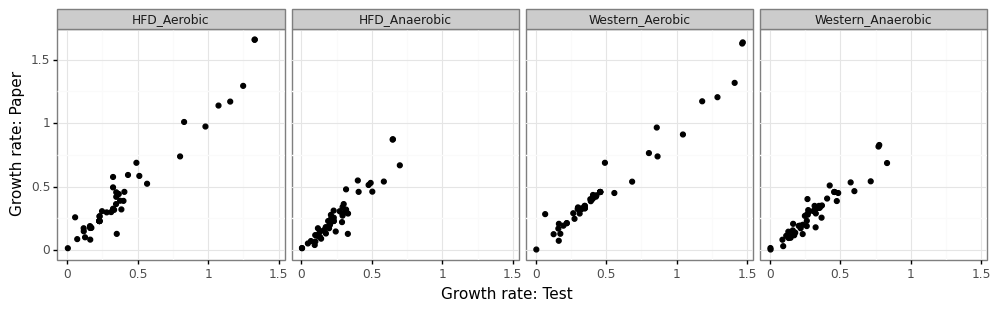

<ggplot: (8771248550991)>

In [327]:
figmat1 = growth_rate.iloc[:, 1:]
figmat1.columns = growth_rate_check.columns
figmat1 = figmat1.melt(id_vars="species", var_name="group", value_name="growth_in_paper")
figmat2 = growth_rate_check.melt(id_vars="species", var_name="group", value_name="growth_estimated")
figmat = pd.merge(figmat1, figmat2, on=["species", "group"])

fig = (
    ggplot(figmat) +
        geom_point(aes(x="growth_estimated", y="growth_in_paper"), color="black") +
        facet_grid("~group") +
        theme_bw() +
        theme(figure_size=(12,3)) +
        xlab("Growth rate: Test") + ylab("Growth rate: Paper")
)
fig

ちなみに目的関数の例は以下の通り。菌体1gDWあたりの構成物質を実験的に計測して式を作っているらしい。https://www.nature.com/articles/nbt.1614

In [356]:
r = model.reactions.get_by_id("biomass388")
r.reaction

'0.0030965 10fthf[c] + 0.0030965 2dmmq8[c] + 0.0030965 5mthf[c] + 0.0030965 ACP[c] + 0.025011 PGP[c] + 0.0030965 adocbl[c] + 0.42793 ala_L[c] + 0.0030965 amet[c] + 0.2467 arg_L[c] + 0.20083 asn_L[c] + 0.20083 asp_L[c] + 40.1102 atp[c] + 0.0030965 ca2[c] + 0.0030965 cl[c] + 0.010648 clpn180[c] + 0.010648 clpnai17[c] + 0.010648 clpni17[c] + 0.0030965 coa[c] + 0.0030965 cobalt2[c] + 0.025011 colipa[c] + 0.084104 ctp[c] + 0.0030965 cu2[c] + 0.076146 cys_L[c] + 0.014475 datp[c] + 0.017565 dctp[c] + 0.017565 dgtp[c] + dnarep[c] + 0.014475 dttp[c] + 0.0030965 fad[c] + 0.0030965 fe2[c] + 0.0030965 fe3[c] + 0.21909 gln_L[c] + 0.21909 glu_L[c] + 0.50987 gly[c] + 0.0030965 gthrd[c] + 0.13541 gtp[c] + 35.5403 h2o[c] + 0.079264 his_L[c] + 0.2418 ile_L[c] + 0.0030965 k[c] + 0.37539 leu_L[c] + 0.28544 lys_L[c] + 0.1278 met_L[c] + 0.0030965 mg2[c] + 0.0030965 mn2[c] + 0.0030965 mqn8[c] + 0.0030965 nad[c] + 0.0030965 nadp[c] + 0.010648 pe180[c] + 0.010648 peai17[c] + 0.010648 pei17[c] + 0.010648 pg180[

In [358]:
model.metabolites.get_by_id("biomass[c]").summary()

Percent,Flux,Reaction,Definition
100.00%,181.8,biomass388,0.0030965 10fthf[c] + 0.0030965 2dmmq8[c] + 0.0030965 5mthf[c] + 0.0030965 ACP[c] + 0.025011 PGP[c] + 0.0030965 adocbl[c] + 0.42793 ala_L[c] + 0.0030965 amet[c] + 0.2467 arg_L[c] + 0.20083 asn_L[c] + 0.20083 asp_L[c] + 40.1102 atp[c] + 0.0030965 ca2[c] + 0.0030965 cl[c] + 0.010648 clpn180[c] + 0.010648 clpnai17[c] + 0.010648 clpni17[c] + 0.0030965 coa[c] + 0.0030965 cobalt2[c] + 0.025011 colipa[c] + 0.084104 ctp[c] + 0.0030965 cu2[c] + 0.076146 cys_L[c] + 0.014475 datp[c] + 0.017565 dctp[c] + 0.017565 dgtp[c] + dnarep[c] + 0.014475 dttp[c] + 0.0030965 fad[c] + 0.0030965 fe2[c] + 0.0030965 fe3[c] + 0.21909 gln_L[c] + 0.21909 glu_L[c] + 0.50987 gly[c] + 0.0030965 gthrd[c] + 0.13541 gtp[c] + 35.5403 h2o[c] + 0.079264 his_L[c] + 0.2418 ile_L[c] + 0.0030965 k[c] + 0.37539 leu_L[c] + 0.28544 lys_L[c] + 0.1278 met_L[c] + 0.0030965 mg2[c] + 0.0030965 mn2[c] + 0.0030965 mqn8[c] + 0.0030965 nad[c] + 0.0030965 nadp[c] + 0.010648 pe180[c] + 0.010648 peai17[c] + 0.010648 pei17[c] + 0.010648 pg180[c] + 0.010648 pgai17[c] + 0.010648 pgi17[c] + 0.15452 phe_L[c] + 0.0030965 pheme[c] + 0.18435 pro_L[c] + proteinsynth[c] + 0.0030965 ptrc[c] + 0.0030965 pydx5p[c] + 0.0030965 q8[c] + 0.0030965 ribflv[c] + rnatrans[c] + 0.17946 ser_L[c] + 0.0030965 sheme[c] + 0.0030965 so4[c] + 0.0030965 spmd[c] + 0.0030965 thf[c] + 0.0030965 thmpp[c] + 0.21107 thr_L[c] + 0.047202 trp_L[c] + 0.12068 tyr_L[c] + 0.025011 udcpdp[c] + 0.090832 utp[c] + 0.35223 val_L[c] + 0.0030965 zn2[c] --> 0.025011 PGPm1[c] + 40.0 adp[c] + 0.0030965 apoACP[c] + biomass[c] + 0.0030965 cbi[c] + 0.0030965 dmbzid[c] + 40.0 h[c] + 39.9969 pi[c] + 0.4846 ppi[c]
Percent,Flux,Reaction,Definition
100.00%,-181.8,EX_biomass(e),biomass[c] <=>


## Figure 2

In [114]:
figmat = pd.merge(s2r, r_meta.rename(columns={"Reaction abbreviation":"reactions"}), how="left", on="reactions").\
    groupby("species").Subsystem.value_counts().rename("n").reset_index().\
    pivot_table(columns="Subsystem", index="species", values="n", fill_value=0).\
    reset_index()
figmat = pd.merge(figmat, meta.rename(columns={"ModelAGORA":"species"}).loc[:, ["species", "Phylum"]], how="left", on="species")
figmat

,species,2-Oxocarboxylic acid metabolism,Alanine and aspartate metabolism,Alkaloid synthesis,Aminobenzoate degradation,Aminophosphonate Metabolism,Aminosugar metabolism,Arginine and Proline Metabolism,Ascorbate and aldarate metabolism,Benzoate degradation,...,Urea cycle,"Valine, leucine, and isoleucine metabolism",Vitamin A metabolism,Vitamin B12 metabolism,Vitamin B2 metabolism,Vitamin B6 metabolism,Wood-Ljungdahl Pathway,beta-Alanine metabolism,tRNA Charging,Phylum
0,Abiotrophia_defectiva_ATCC_49176,0,7,0,1,0,14,14,0,0,...,3,23,0,5,5,7,0,2,1,Firmicutes
1,Acidaminococcus_fermentans_DSM_20731,0,9,0,2,0,14,20,3,1,...,8,25,1,7,14,7,0,2,1,Firmicutes
2,Acidaminococcus_intestini_RyC_MR95,0,7,0,1,0,11,13,3,1,...,4,25,0,8,10,6,0,3,1,Firmicutes
3,Acidaminococcus_sp_D21,0,7,0,1,0,11,12,3,1,...,4,23,0,0,10,7,0,3,1,Firmicutes
4,Acinetobacter_calcoaceticus_PHEA_2,0,11,0,2,1,10,36,5,11,...,8,35,3,16,15,14,0,6,2,Proteobacteria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,Yersinia_frederiksenii_ATCC_33641,0,12,0,2,0,16,38,5,3,...,8,31,1,36,15,14,0,4,2,Proteobacteria
765,Yersinia_kristensenii_ATCC_33638,0,12,0,2,0,16,38,1,2,...,8,30,1,36,15,14,0,4,2,Proteobacteria
766,Yersinia_pseudotuberculosis_YPIII,0,12,0,3,0,16,41,2,2,...,7,29,1,17,16,14,0,4,2,Proteobacteria
767,Yersinia_rohdei_ATCC_43380,0,12,0,2,0,15,38,2,1,...,8,30,1,35,15,14,0,4,2,Proteobacteria


論文Fig.2Bと同様にFirmicutes門にはLipopolysaccharide biosynthesis関連の代謝反応が少数しか存在しないことを確認

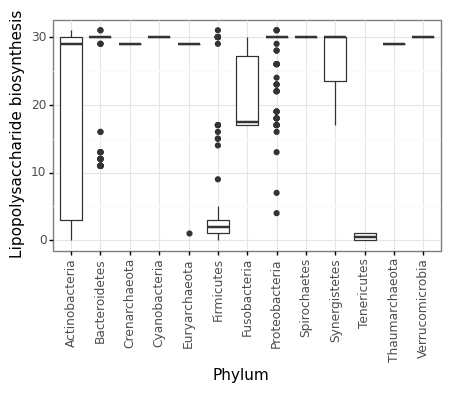

<ggplot: (8771296377010)>

In [124]:
fig = (
    ggplot(figmat) + 
        geom_boxplot(aes(x="Phylum", y="Lipopolysaccharide biosynthesis")) +
        theme_bw() +
        theme(axis_text_x=element_text(angle=90), figure_size=(5,3))
)
fig

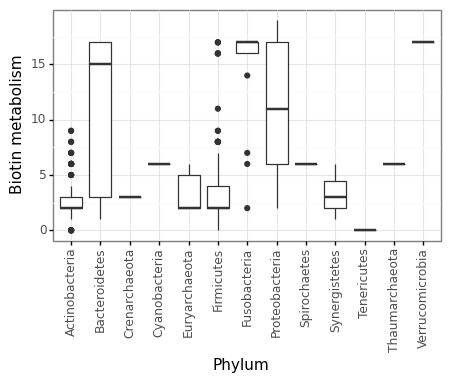

<ggplot: (8771300417175)>

In [125]:
fig = (
    ggplot(figmat) + 
        geom_boxplot(aes(x="Phylum", y="Biotin metabolism")) +
        theme_bw() +
        theme(axis_text_x=element_text(angle=90), figure_size=(5,3))
)
fig

## Fig 3

各細菌がどの物質を利用して生存できるか、どの物質を産生するかをFlux Variability Analysisで解析。

論文によるとBOF (Biomass optimal function)が0.001を上回る状況(細菌が増加する状況)での各代謝の流束の範囲をFVAで推定。`fraction_of_optimum`というオプションでこの条件を設定してみる。

Exchange reactionの最小流束が0よりも下回る場合に「細菌がその物質を環境から取り込む」、最大流束が0よりも高い場合に「細菌がその物質を産生する」と考える。

In [456]:
fig3_reactions = pd.read_table("Magnusdottir-2017-Nat_Biotechnol/fig3_metabolites.tsv")
fig3_reactions.head()

,Reaction,Reaction name,Category
0,EX_glc_D(e),D-Glucose,Simple sugars
1,EX_fru(e),D-Fructose,Simple sugars
2,EX_malt(e),Maltose,Simple sugars
3,EX_man(e),D-Mannose,Simple sugars
4,EX_acgam(e),N-acetyl-D-glucosamine,Simple sugars


In [457]:
def fig3_metabolic_potential(species):
    species2potential = []
    for s in tqdm.tqdm(species):
        file = "AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_sbml/{s}.xml".format(s=s)
        #file = "AGORA/Previous_Versions/AGORA1.02/Agora_102_Reconstruction_sbml/{s}.xml".format(s=s)
        model = cobra.io.read_sbml_model(file)
        op = model.optimize()
        value = op.objective_value
        fva = cobra.flux_analysis.flux_variability_analysis(model, fraction_of_optimum=0.001/value)
        fva_ex = fva.loc[[i.startswith("EX") for i in fva.index],:].\
                    reset_index().rename(columns={"index":"Reaction"}).\
                    merge(fig3_reactions, how="right", on="Reaction").\
                    loc[:, ["Reaction", "Reaction name", "Category", "minimum", "maximum"]].\
                    assign(species = s)
        species2potential.append(fva_ex)
    return pd.concat(species2potential)

### Fusobacterium

論文ではFusobacteriumによるButyrate産生能が確認された、という記述があるが、実際にテストすると同様の傾向を確認できた。

In [443]:
# Fusobacterium
species = meta.query("Genus == 'Fusobacterium'").ModelAGORA
fig3_fusobacterium = fig3_metabolic_potential(species)

100%|██████████| 16/16 [06:23<00:00, 23.96s/it]


In [454]:
uptake_fusobacterium = fig3_fusobacterium.fillna(0).\
    query("Category != 'Fermentation products'").\
    assign(uptake = lambda x: x.minimum < -1e-6).\
    pivot_table(index=["Reaction name", "Category"], columns=["species"], values="uptake").\
    mean(axis=1).sort_values(ascending=False).\
    rename("proportion").reset_index()
uptake_fusobacterium.query("proportion > 0")

,Reaction name,Category,proportion
0,Butyrate (n-C4:0),Others,1.0000
1,N-acetyl-D-glucosamine,Simple sugars,1.0000
2,Pyruvate,Others,0.9375
3,Glycerol,Others,0.9375
4,D-Fructose,Simple sugars,0.8750
5,D-Glucose,Simple sugars,0.6875
6,Succinate,Others,0.5000
7,D-Galactose,Simple sugars,0.3750
8,D-Ribose,Simple sugars,0.3750
9,Fumarate,Others,0.3750


In [455]:
secretion_fusobacterium = fig3_fusobacterium.fillna(0).\
    query("Category == 'Fermentation products'").\
    assign(secretion = lambda x: x.minimum < -1e-6).\
    pivot_table(index=["Reaction name", "Category"], columns=["species"], values="secretion").\
    mean(axis=1).sort_values(ascending=False).\
    rename("proportion").reset_index()
secretion_fusobacterium.query("proportion > 0")

,Reaction name,Category,proportion
0,Acetate,Fermentation products,1.0000
1,Butanol,Fermentation products,1.0000
2,Butyrate (n-C4:0),Fermentation products,1.0000
3,D-Lactate,Fermentation products,1.0000
4,Formate,Fermentation products,1.0000
5,Hydrogen sulfide,Fermentation products,0.9375
6,Succinate,Fermentation products,0.5000
7,Ethanol,Fermentation products,0.4375
8,Indole,Fermentation products,0.4375
9,L-Lactate,Fermentation products,0.2500


### Phylum間比較

主要なPhylumであるActinobacteria, Bacteroidetes, Firmicutes, Proteobacteriaを比較する。全種を計算すると時間がかかるので20種ずつ計算する。

Glycerolの代謝がBacteroidetesで少なく、Succinateの代謝がFirmicutesで少ないなど、Fig3で確認できた傾向が再現できている。

In [468]:
# Actinobacteria
np.random.seed(0) ; np.random.rand(123)
species = meta.query("Phylum == 'Actinobacteria'").ModelAGORA.to_numpy()
idx = np.sort(np.array(np.random.random(20) * len(species), dtype=int))
fig3_actinobacteria = fig3_metabolic_potential(species[idx])

100%|██████████| 20/20 [07:34<00:00, 22.72s/it]


In [469]:
# Bacteroidetes
np.random.seed(0) ; np.random.rand(123)
species = meta.query("Phylum == 'Bacteroidetes'").ModelAGORA.to_numpy()
idx = np.sort(np.array(np.random.random(20) * len(species), dtype=int))
fig3_bacteroidetes = fig3_metabolic_potential(species[idx])

100%|██████████| 20/20 [07:55<00:00, 23.78s/it]


In [476]:
# Firmicutes
np.random.seed(0) ; np.random.rand(200)
species = meta.query("Phylum == 'Firmicutes'").ModelAGORA.to_numpy()
idx = np.sort(np.array(np.random.random(20) * len(species), dtype=int))
fig3_firmicutes = fig3_metabolic_potential(species[idx])

100%|██████████| 20/20 [08:10<00:00, 24.52s/it]


In [475]:
# Proteobacteria
np.random.seed(0) ; np.random.rand(123)
species = meta.query("Phylum == 'Proteobacteria'").ModelAGORA.to_numpy()
idx = np.sort(np.array(np.random.random(20) * len(species), dtype=int))
fig3_proteobacteria = fig3_metabolic_potential(species[idx])

100%|██████████| 20/20 [08:29<00:00, 25.45s/it]


In [482]:
def get_uptake(mat, name):
    return mat.fillna(0).\
        query("Category != 'Fermentation products'").\
        assign(uptake = lambda x: x.minimum < -1e-6).\
        pivot_table(index=["Reaction name", "Category"], columns=["species"], values="uptake").\
        mean(axis=1).\
        rename(name).reset_index()

uptake_phylum = get_uptake(fig3_actinobacteria, "Actinobacteria").\
                    merge(get_uptake(fig3_bacteroidetes, "Bacteroidetes"), on=["Reaction name", "Category"]).\
                    merge(get_uptake(fig3_firmicutes, "Firmicutes"), on=["Reaction name", "Category"]).\
                    merge(get_uptake(fig3_proteobacteria, "Proteobacteria"), on=["Reaction name", "Category"])
uptake_phylum.to_csv("Magnusdottir-2017-Nat_Biotechnol/fig3_test/uptake.tsv", sep="\t", index=False)
uptake_phylum.sort_values("Actinobacteria", ascending=False).head(20)

,Reaction name,Category,Actinobacteria,Bacteroidetes,Firmicutes,Proteobacteria
70,Succinate,Others,1.000000,1.000000,0.60,0.933333
33,Glycerol,Others,0.941176,0.400000,0.85,0.866667
22,D-Glucose,Simple sugars,0.941176,0.533333,0.85,1.000000
21,D-Glucosamine,Simple sugars,0.882353,0.066667,0.70,0.666667
17,D-Fructose,Simple sugars,0.882353,0.133333,0.95,0.800000
51,Maltose,Simple sugars,0.882353,0.333333,0.75,0.666667
71,Sucrose,Simple sugars,0.764706,0.400000,0.70,0.400000
25,D-Ribose,Simple sugars,0.705882,0.133333,0.75,0.533333
54,N-acetyl-D-glucosamine,Simple sugars,0.647059,0.466667,0.75,0.533333
24,D-Mannose,Simple sugars,0.647059,0.400000,0.80,0.600000


In [496]:
means = f
means

,Reaction name,Category,Proportion
0,2-Oxoglutarate,Others,0.279412
1,Amylopectin,Oligo- and polysaccharides,0.058824
2,Amylose,Oligo- and polysaccharides,0.058824
4,Arabinogalactan,Oligo- and polysaccharides,0.046078
5,Arabinoxylan,Oligo- and polysaccharides,0.014706
7,Butyrate (n-C4:0),Others,0.198039
8,Cellobiose,Simple sugars,0.314951
10,Choline,Others,0.083333
11,Citrate,Others,0.423775
16,D-Arabinose,Simple sugars,0.016667


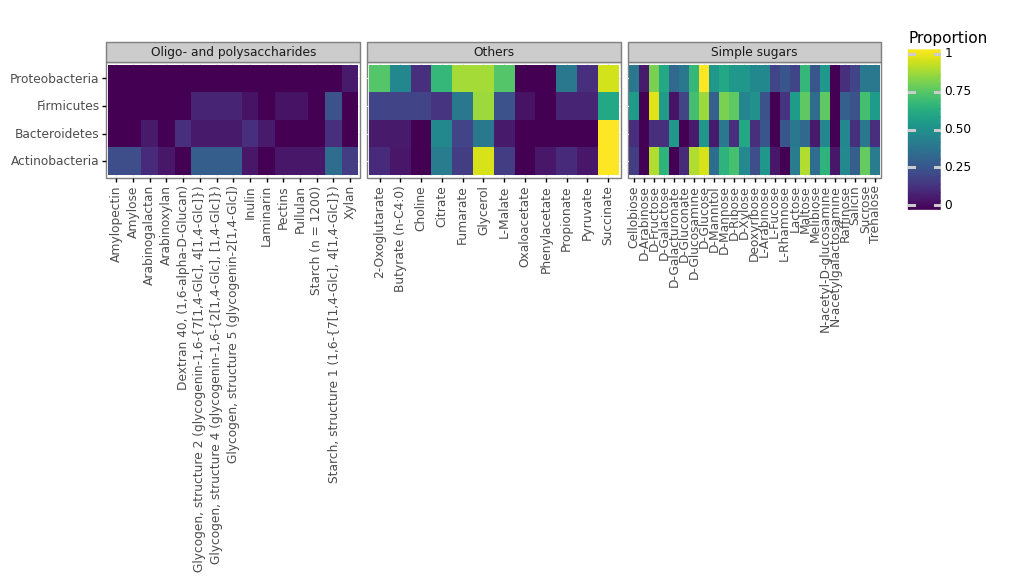

<ggplot: (8771218841293)>

In [510]:
figmat = uptake_phylum.melt(["Reaction name", "Category"], value_name="Proportion", var_name="Phylum")
nonzero = figmat.groupby(["Reaction name", "Category"]).mean().reset_index().query("Proportion != 0").iloc[:,:2]
figmat = figmat.loc[figmat["Reaction name"].isin(nonzero["Reaction name"]), :]
(
    ggplot(figmat) +
        geom_tile(aes(y="Phylum", x="Reaction name", fill="Proportion")) +
        facet_grid("~Category", scales="free_x", space="free_x") +
        theme_bw() +
        theme(axis_text_x=element_text(angle=90), figure_size=(10,1.5)) +
        xlab("") + ylab("")
)

In [483]:
def get_secretion(mat, name):
    return mat.fillna(0).\
        query("Category == 'Fermentation products'").\
        assign(secretion = lambda x: x.maximum > 1e-6).\
        pivot_table(index=["Reaction name", "Category"], columns=["species"], values="secretion").\
        mean(axis=1).\
        rename(name).reset_index()

secretion_phylum = get_secretion(fig3_actinobacteria, "Actinobacteria").\
                    merge(get_secretion(fig3_bacteroidetes, "Bacteroidetes"), on=["Reaction name", "Category"]).\
                    merge(get_secretion(fig3_firmicutes, "Firmicutes"), on=["Reaction name", "Category"]).\
                    merge(get_secretion(fig3_proteobacteria, "Proteobacteria"), on=["Reaction name", "Category"])
secretion_phylum.to_csv("Magnusdottir-2017-Nat_Biotechnol/fig3_test/secretion.tsv", sep="\t", index=False)
secretion_phylum.sort_values("Actinobacteria", ascending=False).head(20)

,Reaction name,Category,Actinobacteria,Bacteroidetes,Firmicutes,Proteobacteria
17,Succinate,Fermentation products,1.000000,1.000000,0.60,0.933333
3,Acetate,Fermentation products,1.000000,1.000000,1.00,0.866667
14,L-Lactate,Fermentation products,0.941176,0.133333,0.70,0.733333
8,Formate,Fermentation products,0.882353,0.800000,0.80,0.933333
10,Hydrogen sulfide,Fermentation products,0.529412,0.266667,0.30,0.866667
7,Ethanol,Fermentation products,0.470588,0.066667,0.65,0.733333
6,D-Lactate,Fermentation products,0.235294,1.000000,0.45,0.666667
2,2-Oxoglutarate,Fermentation products,0.117647,0.066667,0.20,0.733333
16,Propionate,Fermentation products,0.117647,0.000000,0.10,0.400000
5,Butyrate (n-C4:0),Fermentation products,0.058824,0.066667,0.20,0.466667


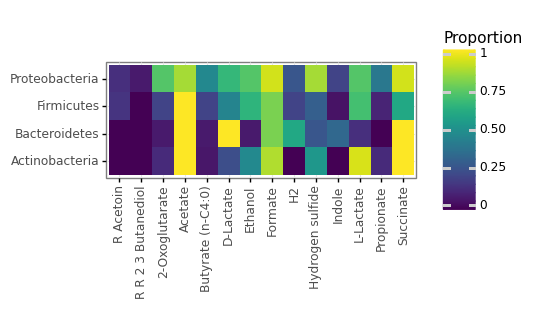

<ggplot: (8771219278845)>

In [513]:
figmat = secretion_phylum.melt(["Reaction name", "Category"], value_name="Proportion", var_name="Phylum")
nonzero = figmat.groupby(["Reaction name", "Category"]).mean().reset_index().query("Proportion != 0").iloc[:,:2]
figmat = figmat.loc[figmat["Reaction name"].isin(nonzero["Reaction name"]), :]
(
    ggplot(figmat) +
        geom_tile(aes(y="Phylum", x="Reaction name", fill="Proportion")) +
        theme_bw() +
        theme(axis_text_x=element_text(angle=90), figure_size=(4,1.5)) +
        xlab("") + ylab("")
)

## Fig 4


Fig.4ではDMEMにおける2種類の細菌の生育・代謝を調べている。

以下のExchange reaction IDが古いIDだったようなのでマニュアルで変更した。

* EX_glc(e) -> EX_glc_D(e)

In [131]:
dmem = pd.read_table("Magnusdottir-2017-Nat_Biotechnol/Medium-DMEM_6429.tsv")
dmem.head()

,Metabolite ID,Exchange reaction ID,Metabolite name,Uptake rate
0,ala_L,EX_ala_L(e),L-alanine,1.0
1,arg_L,EX_arg_L(e),L-arginine,1.0
2,asn_L,EX_asn_L(e),L-asparagine,1.0
3,asp_L,EX_asp_L(e),L-aspartate,1.0
4,cys_L,EX_cys_L(e),L-cysteine,1.0


### Bacteroides caccae ATCC 43185

In [522]:
s = "Bacteroides_caccae_ATCC_43185"
file = "AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_sbml/{s}.xml".format(s=s)
model = cobra.io.read_sbml_model(file)

medium = model.medium
for k in medium.keys(): medium[k] = 0
for ex,val in zip(dmem["Exchange reaction ID"], dmem["Uptake rate"]):
    if model.reactions.has_id(ex): medium[ex] = val
model.medium = medium
op = model.optimize()
print("DMEM with Vitamin K, Hemin, Arabinogalactan: {g}".format(g=op.objective_value))

medium["EX_arabinogal(e)"] = 0
model.medium = medium
op = model.optimize()
print("DMEM with Vitamin K, Hemin: {g}".format(g=op.objective_value))

#medium["EX_mqn7(e)"] = 0
#medium["EX_mqn8(e)"] = 0
medium["EX_pheme(e)"] = 0
model.medium = medium
op = model.optimize()
print("DMEM only: {g}".format(g=op.objective_value))

DMEM with Vitamin K, Hemin, Arabinogalactan: 0.5330796480552902
DMEM with Vitamin K, Hemin: 0.2768354439324188
DMEM only: 0.2768354439324188


### Lactobacillus rhamnosus GG

論文の通りNicotinic acidとL-alanineが存在しないと生育が(ほぼ)ゼロになる傾向を確認した。

In [530]:
s = "Lactobacillus_rhamnosus_GG_ATCC_53103"
file = "AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_sbml/{s}.xml".format(s=s)
model = cobra.io.read_sbml_model(file)

medium = model.medium
for k in medium.keys(): medium[k] = 0
for ex,val in zip(dmem["Exchange reaction ID"], dmem["Uptake rate"]):
    if model.reactions.has_id(ex): medium[ex] = val
model.medium = medium
op = model.optimize()
print("DMEM with Vitamin K, Hemin, Arabinogalactan: {g}".format(g=op.objective_value))

medium["EX_nac(e)"] = 1
model.medium = medium
op = model.optimize()
print("DMEM with Vitamin K, Hemin, Arabinogalactan, Nicotinic acid: {g}".format(g=op.objective_value))

#medium["EX_arabinogal(e)"] = 0
#medium["EX_mqn7(e)"] = 0
medium["EX_mqn8(e)"] = 0
#medium["EX_pheme(e)"] = 0
model.medium = medium
op = model.optimize()
print("DMEM with Nicotinic acid: {g}".format(g=op.objective_value))

medium["EX_ala_L(e)"] = 0
model.medium = medium
op = model.optimize()
print("DMEM with Nicotinic acid w/o L-alanine: {g}".format(g=op.objective_value))

DMEM with Vitamin K, Hemin, Arabinogalactan: 0.0
DMEM with Vitamin K, Hemin, Arabinogalactan, Nicotinic acid: 0.312092469574153
DMEM with Nicotinic acid: 0.312092469574153
DMEM with Nicotinic acid w/o L-alanine: 1.4612128398466525e-16


### Microbe-Microbe interaction

上記２種をDMEM mediumで共培養した場合の相互作用を調べる。[マニュアル](https://opencobra.github.io/cobratoolbox/latest/tutorials/tutorialMicrobeMicrobeInteractions.html)によると細菌間相互作用の推定のための関数はMATLABのCOBRAには用意されているらしいが、COBRApyにはその機能は存在していない。

代替としてCOBRApyのExtension packageである[mminte](https://github.com/mmundy42/MMinte)を使ってみるが、以下のエラーが出た。

In [5]:
import mminte
species = ["Bacteroides_caccae_ATCC_43185", "Lactobacillus_rhamnosus_GG_ATCC_53103"]
model_filenames = ["AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_sbml/{s}.xml".format(s=s) for s in species]
pairs = mminte.get_all_pairs(model_filenames)
pair_model_filenames = mminte.create_interaction_models(pairs, ".")
pair_model_filenames

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


RuntimeError: The heuristic for discovering an external compartment relies on names and boundary reactions. Yet, there are neither compartments with recognized names nor boundary reactions in the model.

エラーの理由がわからないので検証してみる。上記の関数は論文で説明されているように、[2010年の論文](https://doi.org/10.1371/journal.pcbi.1001002)で提案された、細菌間で共有される区画 (lumen) を設けることで、複数生物種のGEMsを連結している。

In [359]:
import six
community_compartment = "u" # lumen
modelseed_suffix_re = re.compile(r'_([ce])$')
bigg_suffix_re = re.compile(r'\[([cepu])\]$')

def _id_type(object_id):
    if re.search(bigg_suffix_re, object_id) is not None:
        return 'bigg'
    if re.search(modelseed_suffix_re, object_id) is not None:
        return 'modelseed'
    return 'unknown'


def _change_compartment(id_str, compartment, id_type):
    if id_type == 'bigg':
        return re.sub(bigg_suffix_re, '[{0}]'.format(compartment), id_str)
    elif id_type == 'modelseed':
        return re.sub(modelseed_suffix_re, '_{0}'.format(compartment), id_str)
    return '{0}_{1}'.format(id_str, compartment)


def create_community_model(model_files, model_names):
    community = cobra.Model('Community')

    # Keep track of the source models. Each element is a tuple with ID and source file name.
    community.notes['species'] = list()

    # IDs of all exchange reactions in the community.
    exchange_reaction_ids = set()

    # IDs of all models in the community (duplicates are not allowed).
    if len(model_names) != len(set(model_names)):
        raise Exception("Duplication in argument 'model_names' is not allowed")

    # Add of the source models to the community model.
    for model_file, model_name in zip(model_files, model_names):
        # Load the model from a file.
        model = cobra.io.read_sbml_model(model_file)

        # Check for multiple objectives in the model (which changed significantly in cobra 0.6).
        linear_coefficients = cobra.util.solver.linear_reaction_coefficients(model)
        objective_id = '{0}_{1}'.format(model_name, six.next(six.iterkeys(linear_coefficients)).id)
        objective_value = six.next(six.itervalues(linear_coefficients))

        # All metabolites need to have a compartment suffix.
        for metabolite in model.metabolites: metabolite.notes['type'] = _id_type(metabolite.id)
        unknown = model.metabolites.query(lambda x: 'unknown' in x['type'], 'notes')
        if len(unknown) > 0:
            raise Exception('Unknown compartment suffixes found in metabolites for {0}'.format(model_file))

        # Get the exchange reactions from the species model.
        exchange_reactions = model.exchanges

        # Add any exchange reactions that are not already in the community model.
        for reaction in exchange_reactions:
            if reaction.id not in exchange_reaction_ids:
                exchange_reaction_ids.add(reaction.id)
                metabolite = six.next(six.iterkeys(reaction.metabolites)).copy()
                metabolite.compartment = community_compartment
                metabolite.id = _change_compartment(metabolite.id, community_compartment, metabolite.notes['type'])
                community.add_metabolites(metabolite)
                rxn = community.add_boundary(metabolite)  # This is slow on cobra06
                rxn.id = reaction.id  # Keep same ID as species model

        # Update the reaction IDs with species prefix and convert exchange reactions to transport reactions.
        for reaction in model.reactions:
            if reaction in exchange_reactions:
                e_metabolite = six.next(six.iterkeys(reaction.metabolites))
                u_metabolite = community.metabolites.get_by_id(
                    _change_compartment(e_metabolite.id, community_compartment, e_metabolite.notes['type']))
                reaction.add_metabolites({u_metabolite: 1.})
                reaction.id = '{0}_TR_{1}'.format(model_name, reaction.id[3:]) # Strip "EX_" prefix
                reaction.bounds = (-1000., 1000.)
            else:
                reaction.id = '{0}_{1}'.format(model_name, reaction.id)

        # Update the metabolite IDs with species prefix.
        for metabolite in model.metabolites:
            if metabolite.compartment != community_compartment:
                metabolite.id = '{0}_{1}'.format(model_name, metabolite.id)

        # Add the species model to the community model.
        community += model
        # Workaround until agreement reached on issue #505.
        objective_reaction = community.reactions.get_by_id(objective_id)
        cobra.util.solver.set_objective(community, {objective_reaction: objective_value}, additive=True)
        species_info = {
            'id': model.id,
            'name': model_name,
            'objective': objective_id,
            'filename': model_file
        }
        community.notes['species'].append(species_info)

    # Update the community ID to include all of the species in the community.
    # Note that the community ID is used as the file name when saving the
    # community model to a JSON file.
    community.id = 'x'.join(model_names)

    return community

In [360]:
species = ["Bacteroides_caccae_ATCC_43185", "Lactobacillus_rhamnosus_GG_ATCC_53103"]
model_files = ["AGORA/CurrentVersion/AGORA_1_03/AGORA_1_03_sbml/{s}.xml".format(s=s) for s in species]
community = create_community_model(model_files, species)

RuntimeError: The heuristic for discovering an external compartment relies on names and boundary reactions. Yet, there are neither compartments with recognized names nor boundary reactions in the model.

上記のエラーメッセージについて調べると以下のメソッドが関わっていそうなことがわかった。`compartments == "u"`が細胞外を表す区画だと認識されていないようだ。おそらくMMINTEが開発された頃からCOBRAの仕様が変わったものと思われる。

In [ ]:
import logging
LOGGER = logging.getLogger(__name__)

def find_external_compartment(model):
    """Find the external compartment in the model.

    Uses a simple heuristic where the external compartment should be the one
    with the most exchange reactions.

    Arguments
    ---------
    model : cobra.Model
        A cobra model.

    Returns
    -------
    str
        The putative external compartment.
    """
    if model.boundary:
        counts = pd.Series(tuple(r.compartments)[0] for r in model.boundary)
        most = counts.value_counts()
        most = most.index[most == most.max()].to_series()
    else:
        most = None
    like_external = cobra.medium.annotations.compartment_shortlist["e"] + ["e"]
    matches = pd.Series(
        [co in like_external for co in model.compartments], index=model.compartments
    )

    if matches.sum() == 1:
        compartment = matches.index[matches][0]
        LOGGER.info(
            "Compartment `%s` sounds like an external compartment. "
            "Using this one without counting boundary reactions" % compartment
        )
        return compartment
    elif most is not None and matches.sum() > 1 and matches[most].sum() == 1:
        compartment = most[matches[most]][0]
        LOGGER.warning(
            "There are several compartments that look like an "
            "external compartment but `%s` has the most boundary "
            "reactions, so using that as the external "
            "compartment." % compartment
        )
        return compartment
    elif matches.sum() > 1:
        raise RuntimeError(
            "There are several compartments (%s) that look "
            "like external compartments but we can't tell "
            "which one to use. Consider renaming your "
            "compartments please."
        )

    if most is not None:
        return most[0]
        LOGGER.warning(
            "Could not identify an external compartment by name and"
            " choosing one with the most boundary reactions. That "
            "might be complete nonsense or change suddenly. "
            "Consider renaming your compartments using "
            "`Model.compartments` to fix this."
        )
    # No info in the model, so give up
    raise RuntimeError(
        "The heuristic for discovering an external compartment "
        "relies on names and boundary reactions. Yet, there "
        "are neither compartments with recognized names nor "
        "boundary reactions in the model."
    )

`model.copartments`が以下のどれかだと、外部環境を表す区画として認識してくれる様子。

In [365]:
cobra.medium.annotations.compartment_shortlist["e"] + ["e"]

['extracellular',
 'extraorganism',
 'out',
 'extracellular space',
 'extra organism',
 'extra cellular',
 'extra-organism',
 'external',
 'external medium',
 'e']

ということで、`community_compartment`を"u"から"out"に変えてみたところ、問題なくコードが動いた。

In [370]:
model_names = species
community = cobra.Model('Community')
community_compartment = "out"

# Keep track of the source models. Each element is a tuple with ID and source file name.
community.notes['species'] = list()

# IDs of all exchange reactions in the community.
exchange_reaction_ids = set()

# IDs of all models in the community (duplicates are not allowed).
if len(model_names) != len(set(model_names)):
    raise Exception("Duplication in argument 'model_names' is not allowed")

# Add of the source models to the community model.
for model_file, model_name in zip(model_files, model_names):
    # Load the model from a file.
    model = cobra.io.read_sbml_model(model_file)

    # Check for multiple objectives in the model (which changed significantly in cobra 0.6).
    linear_coefficients = cobra.util.solver.linear_reaction_coefficients(model)
    objective_id = '{0}_{1}'.format(model_name, six.next(six.iterkeys(linear_coefficients)).id)
    objective_value = six.next(six.itervalues(linear_coefficients))

    # All metabolites need to have a compartment suffix.
    for metabolite in model.metabolites: metabolite.notes['type'] = _id_type(metabolite.id)
    unknown = model.metabolites.query(lambda x: 'unknown' in x['type'], 'notes')
    if len(unknown) > 0:
        raise Exception('Unknown compartment suffixes found in metabolites for {0}'.format(model_file))

    # Get the exchange reactions from the species model.
    exchange_reactions = model.exchanges

    # Add any exchange reactions that are not already in the community model.
    for reaction in exchange_reactions:
        if reaction.id not in exchange_reaction_ids:
            exchange_reaction_ids.add(reaction.id)
            metabolite = six.next(six.iterkeys(reaction.metabolites)).copy()
            metabolite.compartment = community_compartment
            metabolite.id = _change_compartment(metabolite.id, community_compartment, metabolite.notes['type'])
            community.add_metabolites(metabolite)
            rxn = community.add_boundary(metabolite, type="exchange")  # This is slow on cobra06
            rxn.id = reaction.id  # Keep same ID as species model

    # Update the reaction IDs with species prefix and convert exchange reactions to transport reactions.
    for reaction in model.reactions:
        if reaction in exchange_reactions:
            e_metabolite = six.next(six.iterkeys(reaction.metabolites))
            u_metabolite = community.metabolites.get_by_id(
                _change_compartment(e_metabolite.id, community_compartment, e_metabolite.notes['type']))
            reaction.add_metabolites({u_metabolite: 1.})
            reaction.id = '{0}_TR_{1}'.format(model_name, reaction.id[3:]) # Strip "EX_" prefix
            reaction.bounds = (-1000., 1000.)
        else:
            reaction.id = '{0}_{1}'.format(model_name, reaction.id)

    # Update the metabolite IDs with species prefix.
    for metabolite in model.metabolites:
        if metabolite.compartment != community_compartment:
            metabolite.id = '{0}_{1}'.format(model_name, metabolite.id)

    # Add the species model to the community model.
    community += model
    # Workaround until agreement reached on issue #505.
    objective_reaction = community.reactions.get_by_id(objective_id)
    cobra.util.solver.set_objective(community, {objective_reaction: objective_value}, additive=True)
    species_info = {
        'id': model.id,
        'name': model_name,
        'objective': objective_id,
        'filename': model_file
    }
    community.notes['species'].append(species_info)

# Update the community ID to include all of the species in the community.
# Note that the community ID is used as the file name when saving the
# community model to a JSON file.
community.id = 'x'.join(model_names)

There are several compartments that look like an external compartment but `out` has the most boundary reactions, so using that as the external compartment.
There are several compartments that look like an external compartment but `out` has the most boundary reactions, so using that as the external compartment.
There are several compartments that look like an external compartment but `out` has the most boundary reactions, so using that as the external compartment.
There are several compartments that look like an external compartment but `out` has the most boundary reactions, so using that as the external compartment.
There are several compartments that look like an external compartment but `out` has the most boundary reactions, so using that as the external compartment.
There are several compartments that look like an external compartment but `out` has the most boundary reactions, so using that as the external compartment.
There are several compartments that look like an external compar

In [371]:
medium = community.medium
for k in medium.keys(): medium[k] = 0
for ex,val in zip(dmem["Exchange reaction ID"], dmem["Uptake rate"]):
    if community.reactions.has_id(ex): medium[ex] = val
medium["EX_ala_L(e)"] = 0
community.medium = medium
op = community.optimize()
print("DMEM with Vitamin K, Hemin, Arabinogalactan: {g}".format(g=op.objective_value))
print("  {s}: {g}".format(s=community.notes["species"][0]["name"], g=op.fluxes[community.notes["species"][0]["objective"]]))
print("  {s}: {g}".format(s=community.notes["species"][1]["name"], g=op.fluxes[community.notes["species"][1]["objective"]]))

There are several compartments that look like an external compartment but `out` has the most boundary reactions, so using that as the external compartment.
There are several compartments that look like an external compartment but `out` has the most boundary reactions, so using that as the external compartment.


DMEM with Vitamin K, Hemin, Arabinogalactan: 0.6594636038696837
  Bacteroides_caccae_ATCC_43185: 0.4386544423746743
  Lactobacillus_rhamnosus_GG_ATCC_53103: 0.22080916149500934


In [372]:
def get_flux_around_metabolite(metabolite):
    m_flux = metabolite.summary()
    flux_mat = pd.concat([m_flux.consuming_flux.assign(type="consuming"), m_flux.producing_flux.assign(type="producing")]).\
        reset_index().assign(metabolite=metabolite.id).\
        loc[:, ["metabolite", "reaction", "type", "flux"]]
    return flux_mat

ex_metabolites = [m for m in community.metabolites if m.compartment == "out"]
flux_ex_metabolites = pd.concat([get_flux_around_metabolite(m) for m in ex_metabolites], ignore_index=True)
flux_ex_metabolites.head()

,metabolite,reaction,type,flux
0,12ppd_S[out],EX_12ppd_S(e),consuming,0.0
1,12ppd_S[out],Bacteroides_caccae_ATCC_43185_TR_12ppd_S(e),producing,0.0
0,2obut[out],EX_2obut(e),consuming,0.0
1,2obut[out],Bacteroides_caccae_ATCC_43185_TR_2obut(e),producing,0.0
0,4abut[out],EX_4abut(e),consuming,0.0


In [373]:
flux_ex_metabolites_non_zero = flux_ex_metabolites.query("flux != 0")

Arabinogalactanを除いてみると論文と同様にLGGの生育も低下する

In [380]:
medium = community.medium
for k in medium.keys(): medium[k] = 0
for ex,val in zip(dmem["Exchange reaction ID"], dmem["Uptake rate"]):
    if community.reactions.has_id(ex): medium[ex] = val
medium["EX_ala_L(e)"] = 0
medium["EX_arabinogal(e)"] = 0
community.medium = medium
op = community.optimize()
print("DMEM with Vitamin K, Hemin: {g}".format(g=op.objective_value))
print("  {s}: {g}".format(s=community.notes["species"][0]["name"], g=op.fluxes[community.notes["species"][0]["objective"]]))
print("  {s}: {g}".format(s=community.notes["species"][1]["name"], g=op.fluxes[community.notes["species"][1]["objective"]]))

There are several compartments that look like an external compartment but `out` has the most boundary reactions, so using that as the external compartment.
There are several compartments that look like an external compartment but `out` has the most boundary reactions, so using that as the external compartment.


DMEM with Vitamin K, Hemin, Arabinogalactan: 0.3568412244031477
  Bacteroides_caccae_ATCC_43185: 0.24543405369998675
  Lactobacillus_rhamnosus_GG_ATCC_53103: 0.11140717070316093
